In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from utils import bilalic_vs_blom, compute_actual_and_expected_differences_top_players, compute_actual_and_expected_difference
from plots import plot_bilalic_vs_blom, plot_histograms, plot_expected_vs_actual_per_country

# Read and prepare data

In [3]:
df = pd.read_parquet("standard_rating.parquet")
# df = pd.read_parquet("german_rating.parquet")
df = df[df['birthday'] <= 2004]
df = df[(df['flag'].isna()) | (df['flag'] == 'w')]

# Distributions

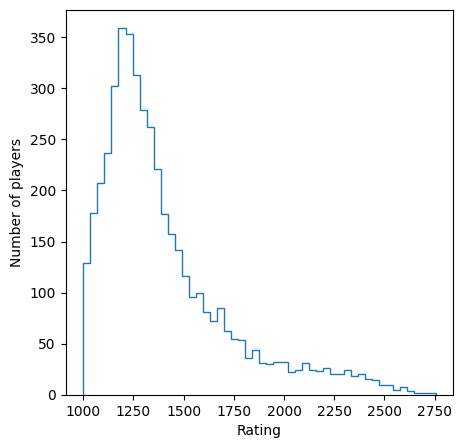

In [4]:
x = df[df['country'] == 'IND']['rating']
plt.figure(figsize=(5, 5))
plt.hist(x, bins=50, histtype='step')
plt.xlabel("Rating")
plt.ylabel("Number of players")
plt.savefig("../../docs/chess-gender-gap/india-distribution.png")

# Difference between best players

In [5]:
countries = df.value_counts(['country'])
countries = countries[countries > 1000]
countries = [x[0] for x in countries.index]

In [6]:
results = compute_actual_and_expected_difference(data=df, countries=countries, n_experiments=1000)

100%|██████████| 28/28 [00:05<00:00,  4.91it/s]


In [7]:
plot_expected_vs_actual_per_country(results, 
                                    save_to="../../docs/chess-gender-gap/countries.html",
                                    sigmas=2)

# Difference between top-k players from a country

## Blom vs Bilalic approximations

Bloom (https://stats.stackexchange.com/a/9007/350686):

$$
E(n, k) \approx \mu + \Phi^{-1} \left( \frac{k - \alpha}{n-2\alpha+1}\right)\sigma
$$

where $\alpha=0.375$

Bilalic (https://cognition.aau.at/download/Publikationen/Bilalic/Bilalic_etal_2009.pdf):

$$
E(n, k) \approx (\mu + c_1 \sigma) + c_2 \sigma \frac{n!}{(n-k)!n^k} (\log n - H(k-1))
$$

where $c_1= 1.25$, $c_2=0.287$, and $H(k) = \sum_{j=1}^k j^{-1}$ is the $k$-th harmonic number.

In [8]:
mu = 1800
s = 300
n = 10_000
ks = range(1, 100, 5)
comparison = bilalic_vs_blom(n=n, mu=mu, sigma=s, ks=ks)

100%|██████████| 20/20 [00:01<00:00, 12.21it/s]


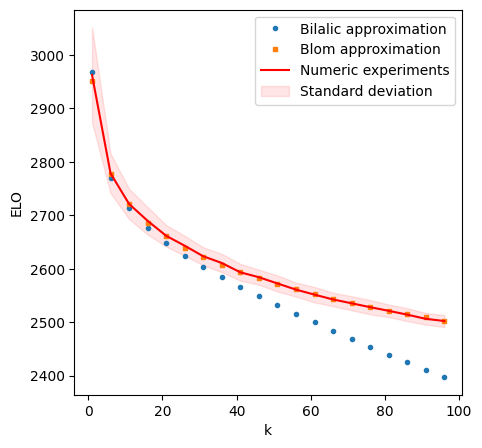

In [9]:
plt.figure(figsize=(5, 5))
plot_bilalic_vs_blom(ks=ks, comparison=comparison)
plt.savefig("../../docs/chess-gender-gap/bilalic-vs-blom.png", bbox_inches="tight")

From the above plot it's clear that Blom approximation is much better than Bilalic's, at least in the regime of number of players, means, and deviations we're moving on.

## Reproducing Bilalic results

In [10]:
country = 'GER'
actual_vs_expected = compute_actual_and_expected_differences_top_players(data=df, 
                                                                         country=country,
                                                                         n_experiments=500,
                                                                         n=50)

1864.2279821627649 274.5016243975781


In [11]:
actual_vs_expected.keys()

dict_keys(['real_diffs', 'normal_expected_difference', 'bootstrap_expected_difference', 'bootstrap_expected_std'])

6908.955999999998


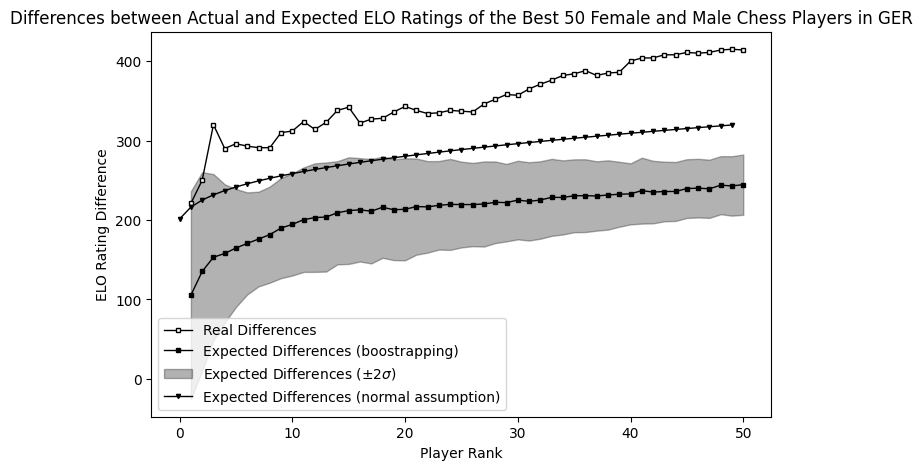

In [12]:
from plots import plot_actual_vs_expected_top_countries
plt.figure(figsize=(8, 5))
plot_actual_vs_expected_top_countries(actual_vs_expected, sigmas=2, country=country, plot_normal_approx=True)
# plt.savefig(f"../../docs/chess-gender-gap/rank-vs-difference-{country}.png", bbox_inches="tight")